# Using NP4VTT: Rouwendal's method

In this notebook, we show how to use Rouwendal's method to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the Rouwendal's method, and Pandas to load the dataset:

In [9]:
import pandas as pd

from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_rouwendal import ConfigRouwendal, ModelRouwendal
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [10]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [11]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [12]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [13]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 0.5370130170428368
Minimum of BVTT: 0.1
Maximum of BVTT: 17.03448275862069


## Step 3: Configure the Rouwendal's method

The Rouwendal's method requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.
* `startQ`: The starting value of the probability of consistent choice.

The function `ConfigRouwendal` takes the configuration parameters of the Rouwendal's method and creates an object that is used by the optimisation routine:

In [14]:
config = ConfigRouwendal(minimum= 0, maximum= 17, supportPoints= 18, startQ= 0.9)

Now, we create the Rouwendal's method object that contains the configuration parameters and the data arrays. Then, we initialise the arguments and we compute the intial log-likelihood function:

In [15]:
rouwendal = ModelRouwendal(config, model_arrays)
initialArgs, initialVal = rouwendal.setupInitialArgs()

## Step 4: Estimate the Rouwendal's method

Once the Rouwendal's method object is initialised, the `run` method starts the optimisation process:

In [16]:
q_prob, q_est, q_se, par, se, fvtt, cumsum_fvtt, vtt_grid, fval, exitflag, output = rouwendal.run(initialArgs)

The estimated model returns the following information:

* `q_prob`: The estimated probability of consistent choice.
* `q_est`: The estimated parameter that generates the probability of consistent choice.
* `q_se`: The standard errors of the parameter of consistent choice.
* `par:` The estimated parameters at each point of the VTT grid.
* `se:` The standard errors of `par`.
* `fvtt`: The VTT probability at each support point.
* `cumsum_fvtt`: The cumulative probability of the VTT at each support point.
* `fval:` Value of the likelihood function in the optimum.
* `vtt_grid:` The VTT grid
* `exitflag:` Exit flag of the optimisation routine.
* `output:` output message of the optimisation routine.

The following lines present the estimated results:

In [19]:
import numpy as np

# Create dataframe
results = pd.Series(cumsum_fvtt,name='Cum. Prob.',index=vtt_grid.astype(int))

print('Estimation results:\n')
print('Final log-likelihood: ' + str(round(fval,2)))
print('Estimated prob. of consistent choice: ' + str(round(q_prob,4)))
print('Estimated parameter of consistent choice: ' + str(round(q_est,4)) + ' (' + str(round(q_se,4)) + ')')
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:

Final log-likelihood: -23335.64
Estimated prob. of consistent choice: 0.9007
Estimated parameter of consistent choice: 2.2049 (0.0002)

Estimated Cumulative probability:
0     0.231896
1     0.554949
2     0.783122
3     0.868718
4     0.907441
5     0.942241
6     0.955989
7     0.966255
8     0.976503
9     0.978266
10    0.978689
11    0.983352
12    0.983380
13    0.985833
14    0.994372
15    0.994438
16    0.994450
17    1.000000
Name: Cum. Prob., dtype: float64


## Step 5: Do plots

We create the ECDF of the VTT distribution. We use matplotlib for this:

(0.0, 20.0)

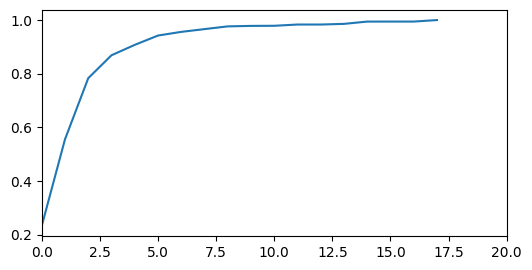

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

ax.plot(vtt_grid,cumsum_fvtt)
plt.xlim([0, 20])